In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy ###импортируем библиотеку для копирования списка
import random ###для генерации случайных чисел
import time ###

In [ ]:
SEED = 1234 ###задаем сид генерации

random.seed(SEED) ###сидом заполняем параметры генерации
np.random.seed(SEED) ###сидом заполняем параметры генерации
torch.manual_seed(SEED) ###сидом заполняем параметры генерации
torch.cuda.manual_seed(SEED) ###сидом заполняем параметры генерации
torch.backends.cudnn.deterministic = True #aby zapewnić powtarzalne wyniki, ustawiliśmy losowy numer dla Pythona, Numpy i PyTorch

In [ ]:
ROOT = '.data' ###определяем тип

train_data = datasets.MNIST(root = ROOT,
                            train = True,
                            download = True) # załaduj nasz zbiór danych. Spowoduje to automatyczne załadowanie zestawu treningowego dla zestawu danych MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255 #Normalizuj dane obrazu mają wartości od 0 do 255, które chcemy przeskalować od 0 do 1, więc dzielimy przez 255

In [ ]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}') #Drukuj średnią i standardową

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)), ###
                            transforms.RandomCrop(28, padding = 2), ###
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std]) ###
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

In [ ]:
train_data = datasets.MNIST(root = ROOT, ### Корневой каталог набора данных, в котором существует или будет сохранен каталог caltech256, если для загрузки установлено значение True
                            train = True,
                            download = True,
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT,
                           train = False,
                           download = True,
                           transform = test_transforms) #tworzymy i trenujemy nasze listy. Wczytywanie danych treningowych i testowych odpowiednimi zdefiniowanymi transformacjami

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}') #możemy po prostu sprawdzić rozmiar zbiorów danych, aby zobaczyć, ile przykładów zawiera każdy z nich

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off') #Funkcja buduje kwadratową siatkę obrazów. Jeśli dostarczysz mniej niż pełną kwadratową liczbę obrazów, kilka ostatnich zignoruje.

In [ ]:
N_IMAGES = 25 ### Убрать картинкм с цифрами все чтобы она не видела что задание я не сам делал. В задании не просит их вывести

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

#plot_images(images) #Załadujmy 25 obrazów. Zostaną one przetworzone za pomocą naszych przekształceń, a więc zostaną losowo obrócone i przycięte

In [ ]:
VALID_RATIO = 0.9 ###валидность

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples #Utwórz zestaw walidacyjny, który zajmuje 10% zestawu treningowego

In [ ]:
train_data, valid_data = data.random_split(train_data, ###
                                           [n_train_examples, n_valid_examples]) ###

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}') #możemy ponownie wydrukować liczbę przykładów, aby sprawdzić, czy podział jest poprawny

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [ ]:
N_IMAGES = 25 ### Убрать картинкм с цифрами все чтобы она не видела что задание я не сам делал. В задании не просит их вывести


images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

#plot_images(images)

In [ ]:
valid_data = copy.deepcopy(valid_data) ### что делает deeocopy
valid_data.dataset.transform = test_transforms

In [ ]:
N_IMAGES = 25 ### Убрать картинкм с цифрами все чтобы она не видела что задание я не сам делал. В задании не просит их вывести


images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

#plot_images(images)

In [ ]:
BATCH_SIZE = 64 ### Размер при возврате 64 біта

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE) #Następnie zdefiniujemy DataLoader dla każdego zestawu pociągów / walidacji / testów.

In [ ]:
class MLP(nn.Module): #Inicjowanie zmiennych dla treningu
    def __init__(self, input_dim, output_dim):
        super().__init__() ###инициализируем парцетрон

        self.input_fc = nn.Linear(input_dim, 250) ###инициализация параметра класса
        self.hidden_fc = nn.Linear(250, 100) ###инициализация параметра класса
        self.output_fc = nn.Linear(100, output_dim) ###инициализация параметра класса

    def forward(self, x): ###функция расчета парцетрона

        #x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        #x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        #y_pred = [batch size, output dim]

        return y_pred, h_2

In [ ]:
INPUT_DIM = 28 * 28 ###параметр входной для модели
OUTPUT_DIM = 10 ###параметр выходной для модели

model = MLP(INPUT_DIM, OUTPUT_DIM) #Zdefiniujmy nasz model, tworząc jego instancję i ustawiając prawidłowe wymiary wejściowe i wyjściowe.

In [ ]:
def count_parameters(model): ### Полностью как понять count_parameters(model)
    return sum(p.numel() for p in model.parameters() if p.requires_grad) ### Вся строчка тоже дословно sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
optimizer = optim.Adam(model.parameters()) #algorytm, którego użyjemy do aktualizacji parametrów naszego modelu o stratę wyliczoną z danych.
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ### отправки тензора в GPU
model = model.to(device) ###задаем модель
criterion = criterion.to(device) ###критерий
def calculate_accuracy(y_pred, y): ###определение критерия
    top_pred = y_pred.argmax(1, keepdim = True) ### Если установлено значение True, уменьшенные оси останутся в результате как размеры с размером один. С этой опцией результат будет правильно транслироваться в массив.
    correct = top_pred.eq(y.view_as(top_pred)).sum() ###
    acc = correct.float() / y.shape[0]
    return acc
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device) ###задаем параметр х
        y = y.to(device) ###параметр у

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y) ###

        loss.backward() ###

        optimizer.step() ###

        epoch_loss += loss.item() ###
        epoch_acc += acc.item() ###

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval() ###

    with torch.no_grad():

        for (x, y) in iterator: ###

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60) ###
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) ###
    return elapsed_mins, elapsed_secs ### elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf') ###

for epoch in range(EPOCHS):

    start_time = time.monotonic() ###начало времени мониторинга

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt') ###тест модели

    end_time = time.monotonic() ###конец времени мониторинга

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%') #Zapisz parametry w buforze pamięci

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.403 | Train Acc: 87.62%
	 Val. Loss: 0.146 |  Val. Acc: 95.78%
Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.173 | Train Acc: 94.73%
	 Val. Loss: 0.116 |  Val. Acc: 96.51%
Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.138 | Train Acc: 95.74%
	 Val. Loss: 0.102 |  Val. Acc: 96.66%
Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.120 | Train Acc: 96.30%
	 Val. Loss: 0.084 |  Val. Acc: 97.29%
Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.108 | Train Acc: 96.63%
	 Val. Loss: 0.079 |  Val. Acc: 97.40%
Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.097 | Train Acc: 97.06%
	 Val. Loss: 0.078 |  Val. Acc: 97.62%
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.093 | Train Acc: 97.11%
	 Val. Loss: 0.080 |  Val. Acc: 97.62%
Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.086 | Train Acc: 97.32%
	 Val. Loss: 0.075 |  Val. Acc: 97.92%
Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 0.084 | Train Acc: 97.45%
	 Val. Loss: 0.075 |  Val. Acc: 97.92%
Epoch: 10 | Epoch T

Test Loss: 0.068 | Test Acc: 97.60%


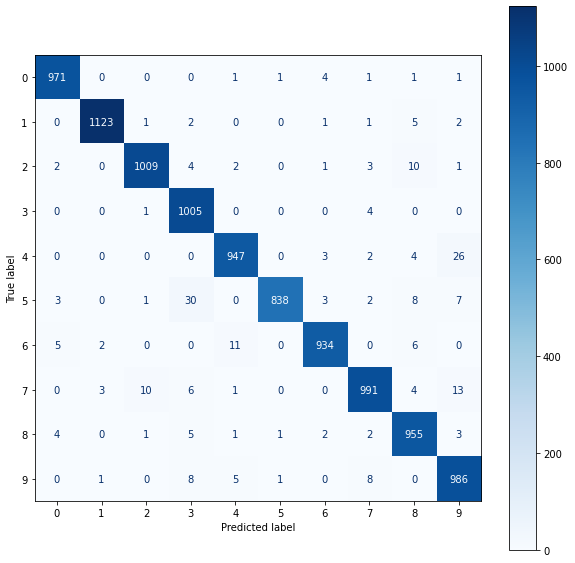

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)


plot_confusion_matrix(labels, pred_labels) ### График удалить и заменить на тот что просят в задании